In [88]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision.models as models
import os

In [89]:
data_face = r"C:\Users\dharu\OneDrive\Desktop\6th Semester\Cryptography\model_face"

In [90]:
data_signature = r"C:\Users\dharu\OneDrive\Desktop\6th Semester\Cryptography\model_sign"

In [99]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [100]:
face_dataset = ImageFolder(data_face, transform=transform)

In [101]:
signature_dataset = ImageFolder(data_signature, transform=transform)

In [102]:
train_size = int(0.8 * len(face_dataset))
test_size = len(face_dataset) - train_size
face_train, face_test = torch.utils.data.random_split(face_dataset, [train_size, test_size])

In [103]:
train_size = int(0.8 * len(signature_dataset))
test_size = len(signature_dataset) - train_size
sign_train, sign_test = torch.utils.data.random_split(signature_dataset, [train_size, test_size])

In [104]:
batch_size = 32
face_loader = DataLoader(face_train, batch_size=batch_size, shuffle=True)
signature_loader = DataLoader(sign_train, batch_size=batch_size, shuffle=True)

In [105]:
test_loader_face = DataLoader(face_test, batch_size=batch_size, shuffle=False)
test_loader_sign = DataLoader(sign_test, batch_size=batch_size, shuffle=False)

In [106]:
base_model_face = models.resnet50(pretrained=True)
base_model_sign = models.efficientnet_v2_s(pretrained=True)

In [107]:
shared_conv = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2)
)


In [108]:
face_branch = nn.Sequential(
    shared_conv,
    nn.Flatten(),
    nn.Linear(128 * 56 * 56, 256),
    nn.ReLU(),
    nn.Linear(256, len(face_dataset.classes))
)


In [109]:
signature_branch = nn.Sequential(
    shared_conv,
    nn.Flatten(),
    nn.Linear(128 * 56 * 56, 256),
    nn.ReLU(),
    nn.Linear(256, len(signature_dataset.classes))
)


In [110]:
combined_model = nn.ModuleDict({
    'face_branch': face_branch,
    'signature_branch': signature_branch
})

In [111]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.001)


In [112]:
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [162]:
losses = []

for epoch in range(num_epochs):
    combined_model.train()
    running_loss = 0.0
    
    for data_face, data_sign in zip(face_loader, signature_loader):
        inputs_face, labels_face = data_face[0].to(device), data_face[1].to(device)
        inputs_sign, labels_sign = data_sign[0].to(device), data_sign[1].to(device)
        
        optimizer.zero_grad()
        
        outputs_face = combined_model['face_branch'](inputs_face)
        outputs_sign = combined_model['signature_branch'](inputs_sign)
        
        loss_face = criterion(outputs_face, labels_face)
        loss_sign = criterion(outputs_sign, labels_sign)
        
        loss = loss_face + loss_sign
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs_face.size(0)
    
    epoch_loss = running_loss / len(face_loader.dataset)
    losses.append(epoch_loss)
   
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/5], Loss: 0.0036
Epoch [2/5], Loss: 0.0020
Epoch [3/5], Loss: 0.0025
Epoch [4/5], Loss: 0.0014
Epoch [5/5], Loss: 0.0006


In [114]:
combined_model.eval()
with torch.no_grad():
    for data_face, data_sign in zip(test_loader_face, test_loader_sign):
        inputs_face, _ = data_face
        inputs_sign, _ = data_sign
        inputs_face = inputs_face.to(device)
        inputs_sign = inputs_sign.to(device)

        outputs_face = combined_model['face_branch'](inputs_face)
        outputs_sign = combined_model['signature_branch'](inputs_sign)

        F_integrated = torch.cat((outputs_face, outputs_sign), dim=1)
        break

In [20]:
print("Final integrated features shape:", F_integrated.shape)
print(F_integrated)

Final integrated features shape: torch.Size([32, 14])
tensor([[ 2.9641e+00,  3.0962e+00,  4.3337e+00,  4.2905e+00, -5.7693e+00,
         -1.6799e+00,  3.0483e+00,  3.6406e+00,  1.1554e+01,  1.1657e+00,
          1.2693e-01,  6.2957e+00, -1.0635e+01,  4.0563e-01],
        [ 9.1186e+00, -1.2620e+00,  5.6955e+00,  6.1230e+00, -1.8501e+01,
          9.3862e+00,  4.3905e+01,  3.3663e+00,  3.2312e+00,  8.4727e-01,
          1.0581e+01, -1.4978e-01, -4.2457e-01, -6.9769e-01],
        [ 4.0424e+00,  2.6578e+00,  2.9190e+00,  5.2123e+00, -1.9787e+00,
         -2.9060e+00, -5.4968e-01,  1.2669e+01, -2.2887e+00, -7.3734e+00,
          3.4977e+00,  1.2071e+01, -3.9584e+00, -3.8776e+00],
        [ 1.3567e+01,  1.1631e+00, -4.8033e-03,  8.1271e+00, -1.1000e-01,
         -8.3431e+00, -9.2738e-01,  4.6420e+00,  1.2672e-01, -7.7741e+00,
          7.5691e-01,  1.3504e+01,  2.2731e+00, -5.7202e+00],
        [ 6.9910e+00, -9.7378e-01,  7.2687e+00,  1.0509e+00, -1.6733e+01,
          5.4406e+00,  4.7022e+0

In [21]:
F_centered = F_integrated - torch.mean(F_integrated, dim=0)

In [22]:
Sigma = torch.matmul(F_centered.T, F_centered) / (len(F_centered) - 1)

In [23]:
Lambda_complex = torch.linalg.eigvals(Sigma)
Lambda = Lambda_complex.real

In [24]:
Lambda_complex, E_complex = torch.linalg.eig(Sigma)
E = E_complex.real

In [25]:
k = 100  
top_k_indices = torch.argsort(Lambda, descending=True)[:k]  
W = E[:, top_k_indices]

In [26]:
F_PCA = torch.matmul(F_centered, W)

In [30]:
M_t_minus_1 = torch.mean(F_PCA, dim=0).numpy()
labels_all_np = np.concatenate((face_dataset.targets, signature_dataset.targets))

In [31]:
labels_face_np = labels_face.cpu().numpy()
labels_sign_np = labels_sign.cpu().numpy()

In [32]:
num_iterations = 10 

In [115]:

from sklearn.decomposition import PCA
import numpy as np
all_F_PCA = []
all_labels_all_np = []
for data_face, data_sign in zip(test_loader_face, test_loader_sign):
    inputs_face, _ = data_face
    inputs_sign, _ = data_sign
    inputs_face = inputs_face.to(device)
    inputs_sign = inputs_sign.to(device)

    outputs_face = combined_model['face_branch'](inputs_face)
    outputs_sign = combined_model['signature_branch'](inputs_sign)
    n_components = min(outputs_face.shape[0], outputs_face.shape[1])  
    pca_face = PCA(n_components=n_components)
    F_PCA_face = pca_face.fit_transform(outputs_face.detach().cpu().numpy())

    
    r_ti_face = labels_face_np - M_t_minus_1[labels_face_np]

    n_components_sign = min(outputs_sign.shape[0], outputs_sign.shape[1])
    pca_sign = PCA(n_components=n_components_sign)
    F_PCA_sign = pca_sign.fit_transform(outputs_sign.detach().cpu().numpy())

    
    r_ti_sign = labels_sign_np - M_t_minus_1[labels_sign_np]

    F_PCA = np.concatenate((F_PCA_face, F_PCA_sign), axis=0)
    r_ti = np.concatenate((r_ti_face, r_ti_sign), axis=0)

    all_F_PCA.append(F_PCA)
    all_labels_all_np.append(r_ti)

    break  


In [35]:
final_model = M_t_minus_1

In [116]:
test_face_loader = DataLoader(face_test, batch_size=batch_size, shuffle=False)
test_sign_loader = DataLoader(sign_test, batch_size=batch_size, shuffle=False)

In [117]:
combined_model.eval()
with torch.no_grad():
    F_PCA_list = []
    all_labels = []

    for data_face, data_sign in zip(test_loader_face, test_loader_sign):
        inputs_face, labels_face = data_face[0].to(device), data_face[1].to(device)
        inputs_sign, labels_sign = data_sign[0].to(device), data_sign[1].to(device)
        
        outputs_face = combined_model['face_branch'](inputs_face)
        outputs_sign = combined_model['signature_branch'](inputs_sign)
        
        F_integrated = torch.cat((outputs_face, outputs_sign), dim=0)  
        F_PCA_list.append(F_integrated)
        all_labels.extend(labels_face.cpu().numpy())
        all_labels.extend(labels_sign.cpu().numpy())

In [118]:
F_PCA = torch.cat(F_PCA_list, dim=0)

In [119]:
print("Shape of F_PCA:", F_PCA.shape)
print("Shape of labels:", len(all_labels))

Shape of F_PCA: torch.Size([136, 7])
Shape of labels: 136


In [120]:
gbm_classifier = GradientBoostingClassifier()

In [121]:
all_labels_np = np.array(all_labels)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(F_PCA.cpu().numpy(), all_labels_np, test_size=0.2, random_state=42)

In [123]:
gbm_classifier.fit(X_train,y_train)

GradientBoostingClassifier()

In [124]:
from sklearn.metrics import classification_report

In [125]:
print(classification_report(y_test,gbm_classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.67      0.80      0.73         5
           2       1.00      1.00      1.00         4
           3       1.00      0.86      0.92         7
           4       0.50      0.33      0.40         3
           5       1.00      1.00      1.00         7
           6       0.50      1.00      0.67         1

    accuracy                           0.86        28
   macro avg       0.81      0.86      0.82        28
weighted avg       0.87      0.86      0.86        28



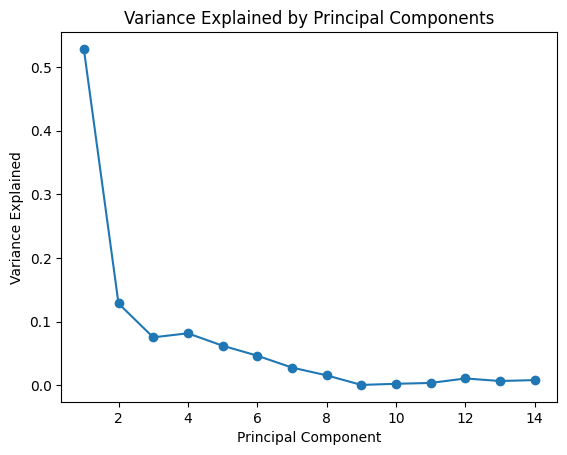

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import torch

if isinstance(Lambda, torch.Tensor):
    Lambda = Lambda.cpu().numpy()

plt.plot(range(1, len(Lambda) + 1), Lambda / np.sum(Lambda), marker='o', linestyle='-')
plt.title('Variance Explained by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()


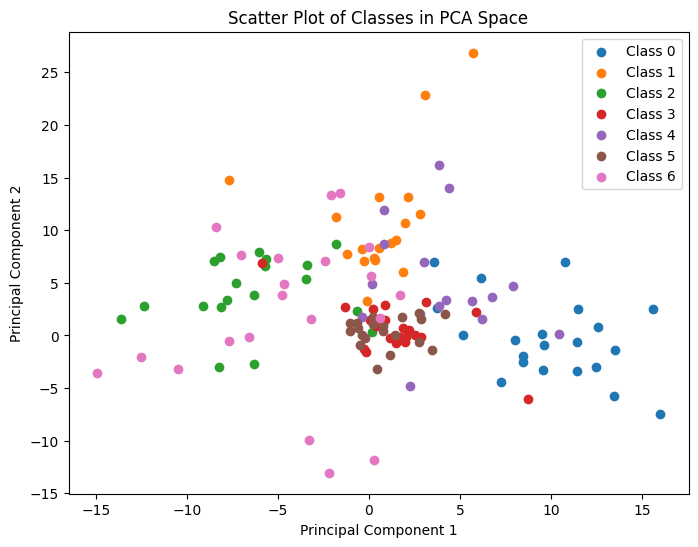

In [127]:
plt.figure(figsize=(8, 6))
for i in range(len(face_dataset.classes)):
    plt.scatter(F_PCA[all_labels_np == i, 0], F_PCA[all_labels_np == i, 1], label=f'Class {i}')
plt.title('Scatter Plot of Classes in PCA Space')
plt.xlabel('Facial Image Features')
plt.ylabel('Signature Image Features')
plt.legend()
plt.show()


In [128]:
all_labels_all_np

[array([5.00000054e+00, 1.54972076e-06, 6.00000006e+00, 4.00000072e+00,
        5.00000054e+00, 2.00000042e+00, 1.54972076e-06, 2.00000042e+00,
        1.54972076e-06, 5.00000054e+00, 5.00000054e+00, 1.00000009e+00,
        5.00000054e+00, 2.00000042e+00, 1.00000009e+00, 6.00000006e+00,
        6.00000006e+00, 1.54972076e-06, 6.00000006e+00, 4.00000072e+00,
        5.00000054e+00, 4.00000072e+00, 2.00000042e+00, 4.00000072e+00])]

In [133]:
from sklearn.preprocessing import label_binarize

In [134]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

In [135]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(face_dataset.classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [136]:
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

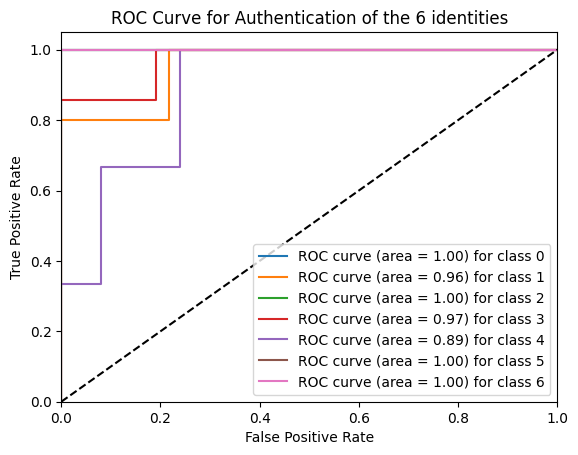

In [146]:
plt.figure()
for i in range(len(face_dataset.classes)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Authentication of the 6 identities')
plt.legend(loc="lower right")
plt.show()

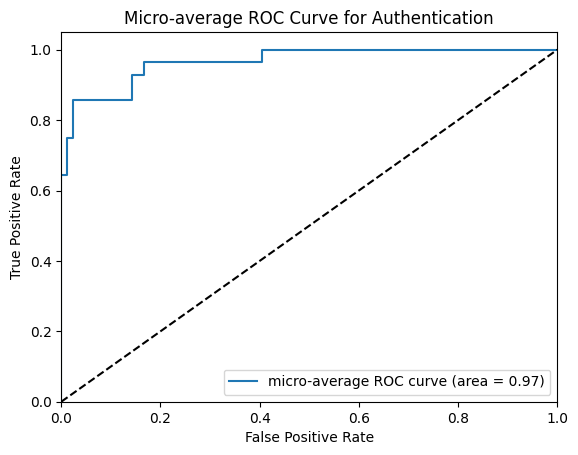

In [142]:
plt.figure()
plt.plot(fpr_micro, tpr_micro, label='micro-average ROC curve (area = %0.2f)' % roc_auc_micro)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve for Authentication')
plt.legend(loc="lower right")
plt.show()

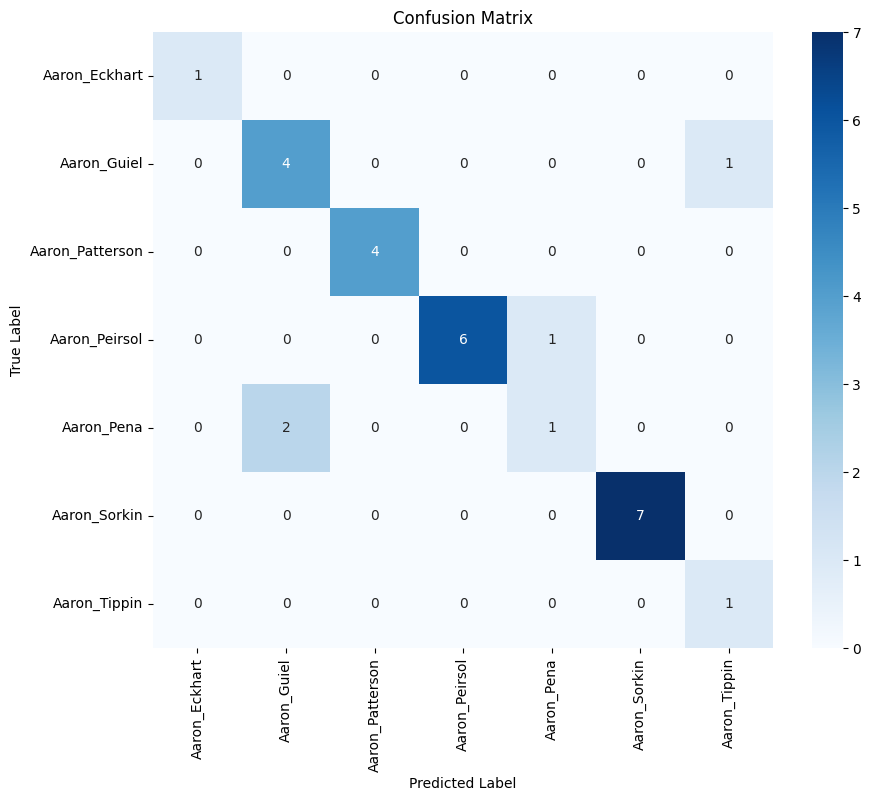

In [145]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, gbm_classifier.predict(X_test))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=face_dataset.classes, yticklabels=face_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [157]:
loss_plot = []
for i in losses:
    loss_plot.append(i.detach().item())

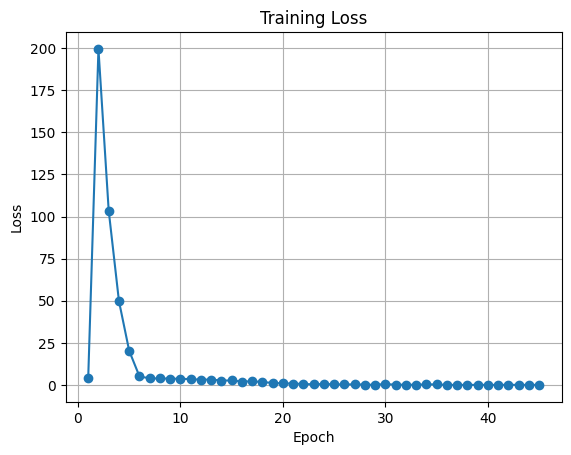

In [161]:
plt.plot(range(1, len(loss_plot) + 1),loss_plot, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

In [163]:
losses_np = np.array(losses)

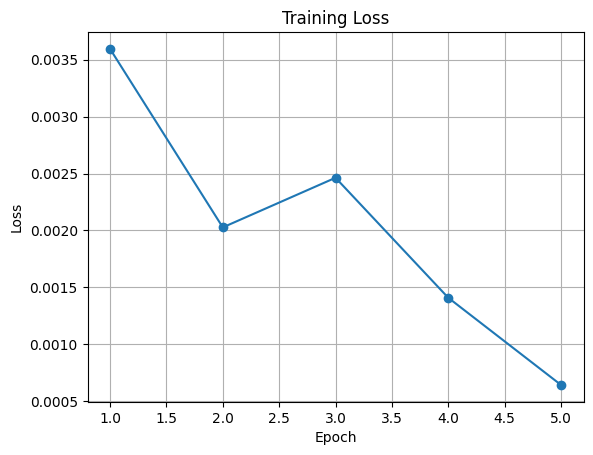

In [164]:
plt.plot(range(1, num_epochs+1), losses_np, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

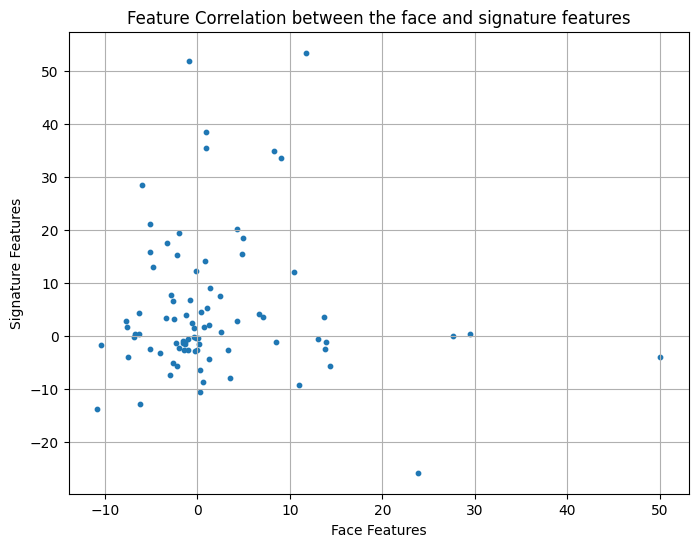

In [167]:
plt.figure(figsize=(8, 6))
plt.scatter(outputs_face.detach().cpu().numpy(), outputs_sign.detach().cpu().numpy(), s=10)
plt.xlabel('Face Features')
plt.ylabel('Signature Features')
plt.title('Feature Correlation between the face and signature features')
plt.grid(True)
plt.show()

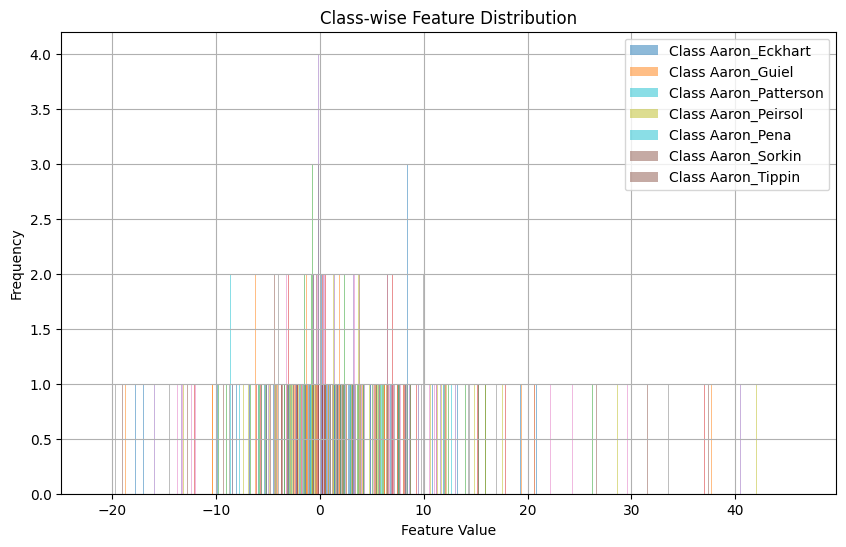

In [172]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 6))
for i in range(len(face_dataset.classes)):    
    feature_values = F_PCA[all_labels_np == i]
    plt.hist(feature_values, bins=50, alpha=0.5, label=f'Class {face_dataset.classes[i]}')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.title('Class-wise Feature Distribution')
plt.legend()
plt.grid(True)
plt.show()


In [169]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(F_PCA)

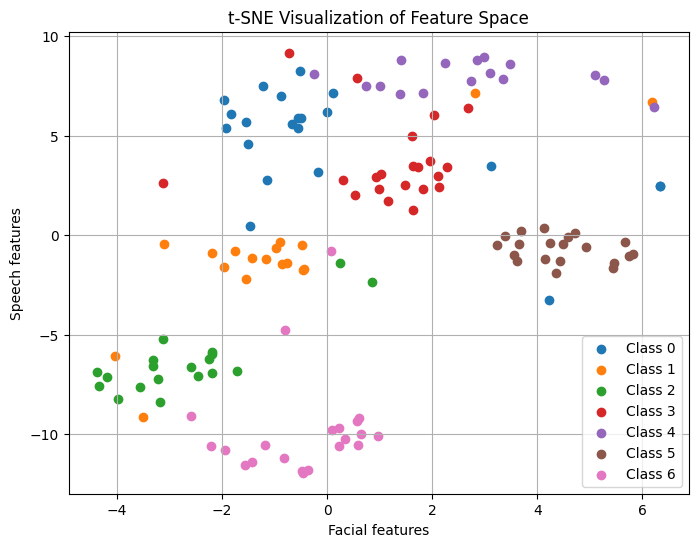

In [171]:
plt.figure(figsize=(8, 6))
for i in range(len(face_dataset.classes)):
    plt.scatter(features_tsne[all_labels_np == i, 0], features_tsne[all_labels_np == i, 1], label=f'Class {i}')
plt.title('t-SNE Visualization of Feature Space')
plt.xlabel('Facial features')
plt.ylabel('Speech features')
plt.legend()
plt.grid(True)
plt.show()